## Домашнее задание «Элементарные методы анализа временных рядов»

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
sales_of_company_x = pd.read_csv("../1-Знакомство с временными рядами/Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("../1-Знакомство с временными рядами/Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("../1-Знакомство с временными рядами/Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("../1-Знакомство с временными рядами/Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("../1-Знакомство с временными рядами/Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("../1-Знакомство с временными рядами/Series/daily-total-female-births-in-cal.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

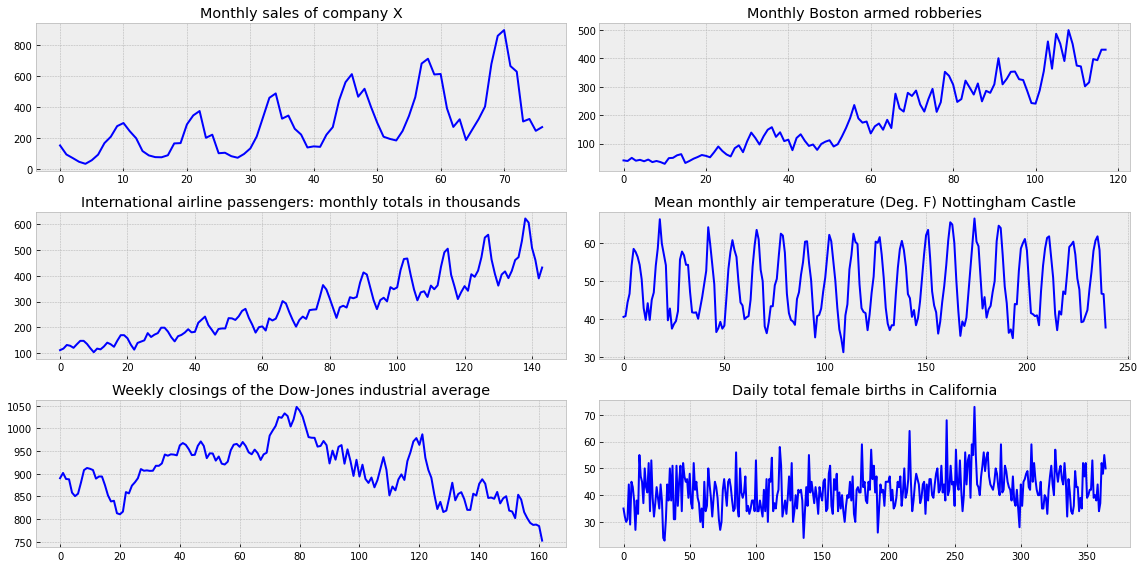

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Возьмем ряд "Monthly Boston armed robberies"

In [6]:
series = robberies_in_boston["Count"]

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

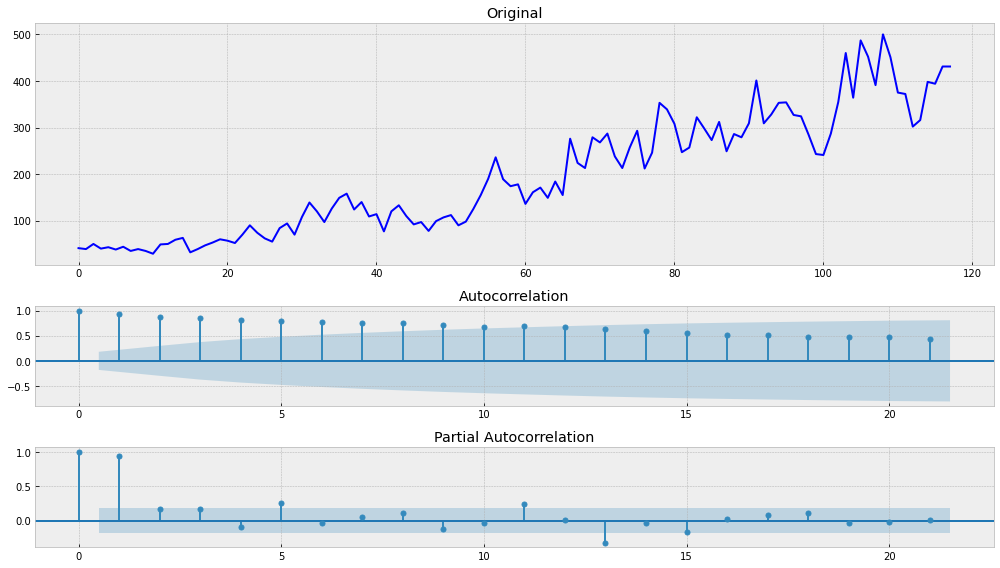

In [8]:
tsplot (series)

Видим, что ряд нестационарный, присутствуют тренд и сезонность.
Поэтому применим метод Хольта - Винтера.

# Хольт-Винтерс

Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [9]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [10]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [11]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [12]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=20):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

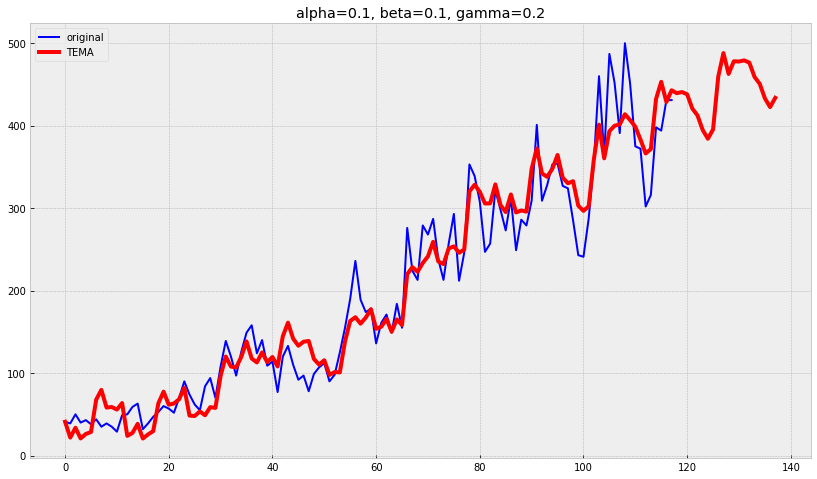

In [13]:
plot_tema(0.1, 0.1, 0.2)

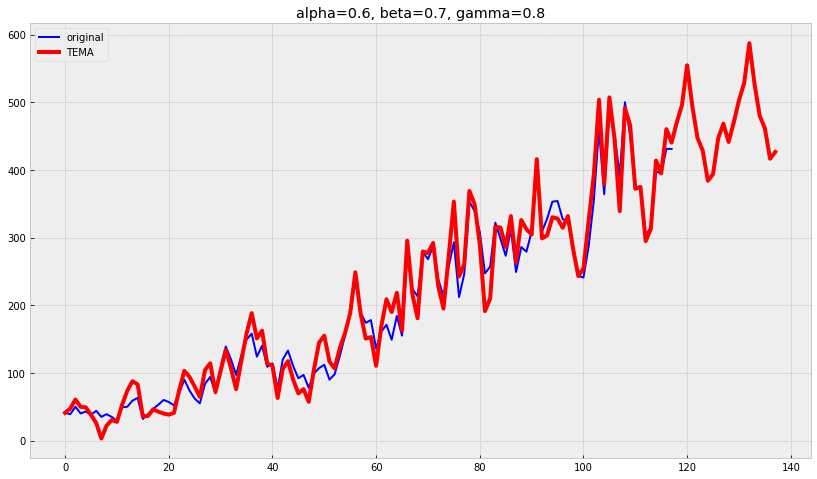

In [14]:
plot_tema(0.6, 0.7, 0.8)

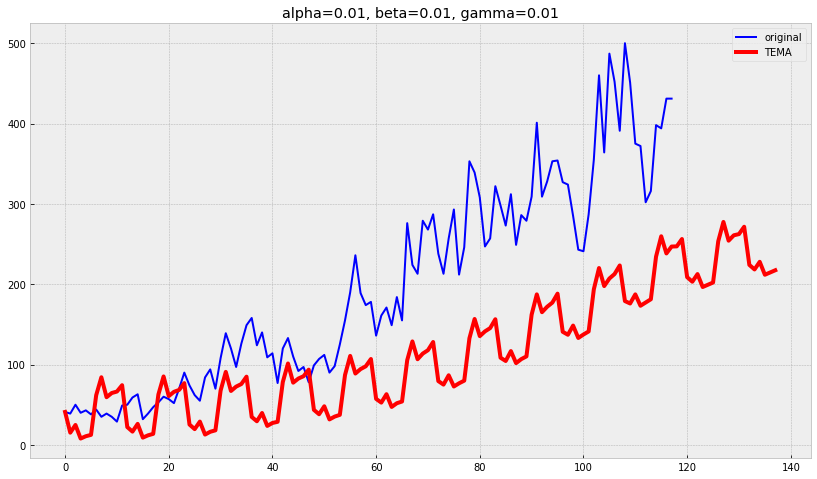

In [15]:
plot_tema(0.01, 0.01, 0.01)

# Подбор параметров

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [16]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [17]:
len(series)

118

In [18]:
train, test, val = series[:100], series[100:115], series[115:]

In [19]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [20]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [21]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4095.9334511002744
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 10.24013727, -10.09962034,  -0.04415597])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 328
      nit: 56
   status: 0
  success: True
        x: array([0.00170878, 1.        , 0.45763538])


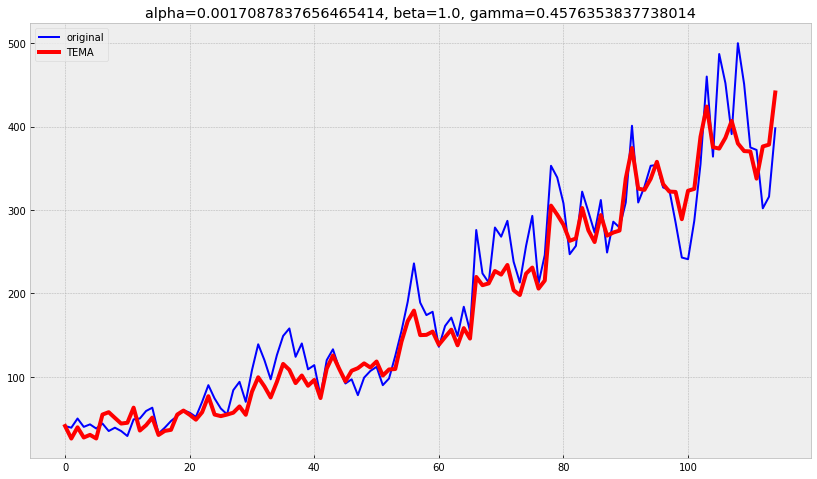

In [22]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:115], n_preds=len(test))

In [23]:
tes = triple_exponential_smoothing(series, 12, alpha_opt, beta_opt, gamma_opt, 0)
error_tes = mean_squared_error(tes, series) 
error_tes

672.0585334298743

Приведем ряд к стационарности

Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


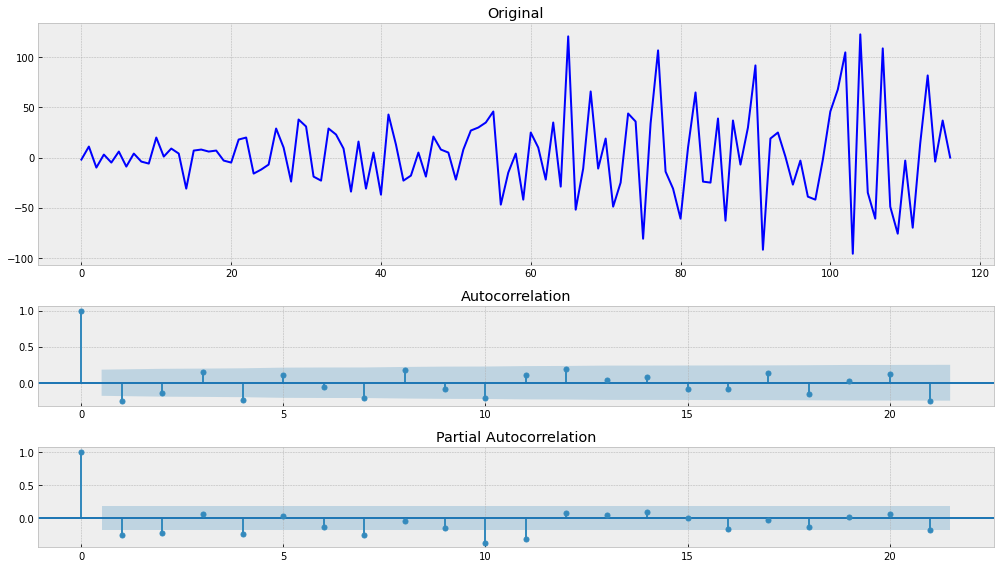

In [24]:
# Нормализуем дисперсию
series_st = boxcox(series, 0)
# дифференцируем
series_st = np.diff(series, 1)
# тест ДФ
dftest = adfuller(series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)
# кореллограмма
tsplot(series_st)

Ряд стационарный, применим к нему WMA, В качестве коэффициентов возьмем числа Фиббоначи

In [25]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [26]:
wma = weighted_moving_average(series_st, 7, [1,1,2,3,5,8,13])

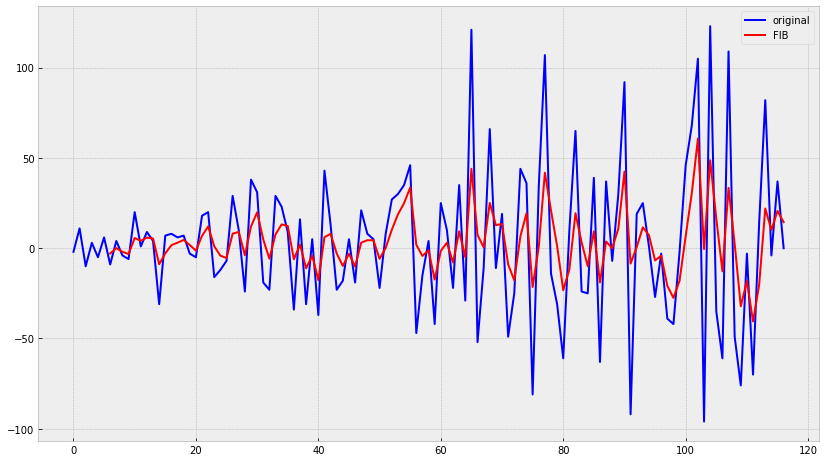

In [27]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='original')
    plt.plot(wma, color='red', linewidth='2', label='FIB')
    plt.legend()

In [28]:
error_wma = mean_squared_error(wma[50:], series_st[50:]) 
error_wma

1409.6389265792254